In [64]:
import random
import time
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from collections import deque
from pprint import pprint

# IPython
from IPython.display import clear_output

#ML
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

In [65]:
# Environment

@dataclass
class QSettings():
    epsilon: float
    epsilon_min = 0.01
    epsilon_decay = 0.99
    discount: float
    learning_rate: float
        
class RunInfo:
    def __init__(self, nepisodes, ntimes):
        self.trainstart = None
        self.trainend = None
        self.scores = {str(i):[] for i in range(nepisodes)}
    
    def start_training(self):
        if self.trainstart is None:
            self.trainstart = time.time()
    
    def end_training(self):
        if self.trainstart is not None:
            self.trainend = time.time()
    
    def get_training_time(self):
        if self.trainend is not None:
            return self.trainend - self.trainstart
    
    def reset_traintime(self):
        self.trainstart = None
        self.trainend = None
    
    def add_score(self, episode, time, score):
        self.scores[str(episode)].append(score)

class Environment():
    def __init__(self, nrows: int, ncols: int, starting_location: tuple, end_location: tuple, nobstacles: int, qsettings: QSettings):
        self.nrows = nrows
        self.ncols = ncols
        self.mapsize = (nrows, ncols)
        self.starting_location = starting_location
        self.startingrow, self.startingcol = self.starting_location
        self.end_location = end_location
        self.endrow, self.endcol = self.end_location
        self.nobstacles = nobstacles
        self.qsettings = qsettings
        self.actions = ['up', 'down', 'left', 'right']
        self.nstates = 2 # vertical movement (rows), horizontal movement (cols)
        
        self.currentrow, self.currentcol = self.starting_location
        
        self.obstacles = []
        self.rewards = np.full((self.nrows, self.ncols), -1.)
        self.qtable = np.zeros((self.nrows, self.ncols, len(self.actions))) # nrows x ncols x nactions
        
        self.basereward = -1
        self.enemyreward = -300
        self.endreward = 300
        
        self.__build_obstacles__()
        self.__build_rewards__()
        
        self.memory = deque(maxlen=50000)
        self.model = self.__build_model__()
        self.target_model = self.__build_model__()
        self.update_target_model()
        
        self.initialized = True
        self.trained = False
        self.ran = False
    
    def __build_model__(self):
        # Neural Net for Deep-Q learning Model
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.nstates, activation='relu'))
        #model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(len(self.actions), activation='linear'))
        model.compile(loss='mse', optimizer=optimizers.Adam(lr=self.qsettings.learning_rate))
        return model
        
    def __build_obstacles__(self):
        if len(self.obstacles) <= 0:
            while len(self.obstacles) < self.nobstacles:
                randrow = np.random.randint(self.nrows)
                randcol = np.random.randint(self.ncols)
                if (randrow, randcol) not in self.obstacles:
                    if (randrow,randcol) != self.starting_location and (randrow,randcol) != self.end_location:
                        self.obstacles.append((randrow, randcol))
                        
    def __build_rewards__(self):
        for obstacle in self.obstacles:
            ob_row, ob_col = obstacle
            self.rewards[ob_row][ob_col] = self.enemyreward
        self.rewards[self.end_location[0]][self.end_location[1]] = self.endreward
    
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())
    
    
    def is_enemy(self, row, col):
        return self.rewards[row][col] == self.enemyreward
    def is_end(self, row, col):
        return self.rewards[row][col] == self.endreward
    
    def get_next_action(self, current_row_index, current_column_index):
        """Next action is decided based on the epsilon-greedy algorithm.
        If a random number is smaller than a value epsilon, the max value from the queue table is selected.
        Otherwise, if the random number is larger, pick a random action
        """
        if np.random.random() < self.qsettings.epsilon:
            x = self.build_state(self.currentrow, self.currentcol)
            act_values = self.model.predict(x) # Main difference between vanilla q-learning and DQL
            return np.argmax(act_values[0])  # returns action
        else: #choose a random action
            return np.random.randint(len(self.actions))
        
    def get_next_location(self,current_row_index, current_column_index, action_index: int):
        new_row_index = current_row_index
        new_column_index = current_column_index
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'right' and current_column_index < self.ncols - 1:
            new_column_index += 1
        elif self.actions[action_index] == 'down' and current_row_index < self.nrows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        return new_row_index, new_column_index
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.qsettings.discount * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.qsettings.epsilon > self.qsettings.epsilon_min:
            self.qsettings.epsilon *= self.qsettings.epsilon_decay
    
    def showmap(self):
        if len(self.obstacles) > 0:
            fig, ax = plt.subplots(figsize=(9,9))
            ax.set_title("Reward map")
            ax.set_xlabel("col")
            ax.set_ylabel("row")
            rewardmap = self.rewards
            rewardmap[self.startingrow][self.startingcol] = -50
            ax.imshow(rewardmap)
            plt.show()
    
    def reset(self):
        self.currentrow = self.startingrow
        self.currentcol = self.startingcol
        
    def build_state(self, currenrow, currentcol):
        return np.array([[self.currentrow, self.currentcol],])
            
    def train(self, epochs: int, epoch_max_time: int, batch_size: int, verbose: bool = False):
        self.runinfo = RunInfo(epochs, epoch_max_time)
        done = False
        for epoch in range(epochs):
            self.reset()
            row, col = self.starting_location
            state = self.build_state(self.currentrow, self.currentcol)
            for time in range(epoch_max_time): # 500
                print(f"Running time {time}/{epoch_max_time-1} for epoch {epoch}/{epochs-1}", end='\r', flush=True)
                ### Choose an action using the epsilon-greedy algorithm
                actionindex = self.get_next_action(self.currentrow, self.currentcol)
                # Take the step and calculate new state
                self.currentrow, self.currentcol = self.get_next_location(self.currentrow, self.currentcol, actionindex)
                newstate = self.build_state(self.currentrow, self.currentcol)
                # Calculate reward
                reward = self.rewards[self.currentrow][self.currentcol]
                done = self.is_end(self.currentrow, self.currentcol) or self.is_enemy(self.currentrow, self.currentcol)
                # Store transition ( s,a,r,s',done )
                self.memorize(state, actionindex, reward, newstate, done)
                state = newstate
                if done:
                    self.update_target_model()
                    print("episode: {}/{}, score: {}, e: {:.2}"
                          .format(epoch, epochs-1, time, self.qsettings.epsilon))
                    break
                else:
                    if len(self.memory) > batch_size: # If enough experiences in memory -> replay
                        self.replay(batch_size)
                self.runinfo.add_score(epoch, time, self.qsettings.epsilon)
        self.trained = True
        
    
    def run(self, maxiterations: int = 10000, verbose: bool = False):
        if self.is_enemy(self.startingrow, self.startingcol) or self.is_end(self.startingrow, self.startingcol):
            return []
        else:
            self.reset()
            shortestpath = []
            shortestpath.append(self.starting_location)
            #i: int = 0
            while (not self.is_end(self.currentrow, self.currentcol)) and (not self.is_enemy(self.currentrow, self.currentcol)):
                actionindex = self.get_next_action(self.currentrow, self.currentcol)
                self.currentrow, self.currentcol = self.get_next_location(self.currentrow, self.currentcol, actionindex)
                shortestpath.append((self.currentrow, self.currentcol))
                #i+=1
                #if (i >= maxiterations):
                #    print(f"Reached maximum iterations {maxiterations}. Current position: ({self.currentrow},{self.currentcol})")
                #    return []
            self.ran = True
            return shortestpath
    
    def showpath(self, shortestpath: list):
        if self.run and len(shortestpath) > 0:
            newmap = self.rewards
            newmap[self.startingrow][self.startingcol] = -50
            for pos in shortestpath:
                r, c = pos
                newmap[r][c] = 100
            fig, ax = plt.subplots(figsize=(9,9))
            ax.set_title("Reward map")
            ax.set_xlabel("col")
            ax.set_ylabel("row")
            ax.imshow(newmap)
            plt.show()
    
            
        

In [66]:
e = Environment(
    30,30,
    (1,1),
    (28,28),
    100,
    QSettings(epsilon=0.9, discount=0.95, learning_rate=0.01)
)

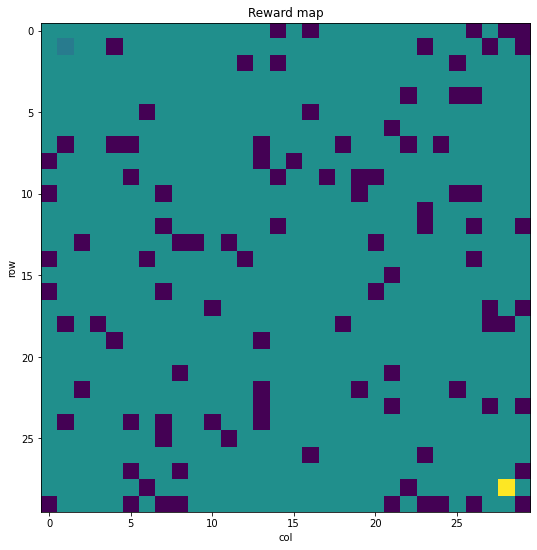

In [67]:
e.showmap()

In [68]:
e.train(4, 64, 32) 

episode: 1/3, score: 26, e: 0.53
episode: 3/3, score: 31, e: 0.19


In [72]:
e.runinfo.scores

{'0': [0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.891,
  0.88209,
  0.8732691,
  0.8645364090000001,
  0.85589104491,
  0.8473321344609,
  0.8388588131162911,
  0.8304702249851281,
  0.8221655227352769,
  0.8139438675079241,
  0.8058044288328449,
  0.7977463845445164,
  0.7897689206990712,
  0.7818712314920805,
  0.7740525191771597,
  0.7663119939853881,
  0.7586488740455342,
  0.7510623853050789,
  0.7435517614520281,
  0.7361162438375077,
  0.7287550813991327,
  0.7214675305851413,
  0.7142528552792899,
  0.707110326726497,
  0.700039223459232,
  0.6930388312246396,
  0.6861084429123933,
  0.6792473584832693,
  0.6724548848984366,
  0.6657303360494523,
  0.6590730326889578,
  0.6524823023620682],
 '1': [0.6459574793384475,
  0.6394979045450631,
  0.6331029254996124,
  0.6267718962446163,
  0.620504177282

In [69]:
shortestpath = e.run()

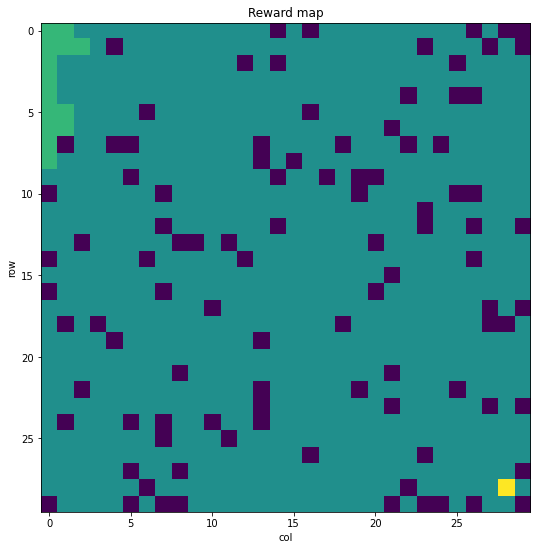

In [70]:
e.showpath(shortestpath)

In [71]:
print(shortestpath)

[(1, 1), (1, 2), (1, 1), (0, 1), (1, 1), (0, 1), (1, 1), (1, 0), (1, 0), (1, 0), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 0), (5, 1), (6, 1), (6, 0), (7, 0), (8, 0)]
